In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import PauliFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator, Sampler
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.utils.loss_functions import L2Loss # Qiskit ML loss, or use PyTorch's
from qiskit_machine_learning.circuit.library import QNNCircuit

# QNNR

In [2]:
if_del_outlier = False
# Read from all csv files
df_all = pd.DataFrame()
for filename in glob.glob("./QNNR_hybrid/result/FMR*"):
    df_tmp = pd.read_csv(filename)
    df_all = pd.concat([df_all, df_tmp.drop(columns=['info'])], ignore_index=True)

# Get the unique list of all 
test_el_list = df_all['element test'].unique()
entangle_list = df_all['entanglement'].unique()
feature_map_reps_list = df_all['feature_map_reps'].unique()
feature_map_reps_list.sort()
ansatz_reps_list = df_all['ansatz_reps'].unique()
ansatz_reps_list.sort()

output_entangle = []
output_feature_map_reps = []
output_ansatz_reps = []
output_r2 = []
output_r2_all = []

# Loop over testing parameters
for entangle in entangle_list:
    for feature_map_reps in feature_map_reps_list:
        for ansatz_reps in ansatz_reps_list:
            # print(entangle, feature_map_reps, ansatz_reps)
            output_entangle.append(entangle)
            output_feature_map_reps.append(feature_map_reps)
            output_ansatz_reps.append(ansatz_reps)
            
            # get results for specified testing parameters
            df = df_all[(df_all['entanglement'] == entangle) 
                & (df_all['feature_map_reps'] == feature_map_reps)
                & (df_all['ansatz_reps'] == ansatz_reps)]

            # One way to assess accuracy is to list all testing 
            # results (for different splits) and to take the R2 based on those.
            el_list = []
            predict_list = []
            actural_list = []
            for el in test_el_list:
                # actual value
                tmp2 = df[df['element test'] == el]['actual test']
                actural_val = np.fromstring(tmp2.to_list()[0][1:-1], dtype=float, sep=" ")[0]
            
                # predicted values
                tmp = df[df['element test'] == el]['predicted test']
                test_predict_list = []
                for ii in tmp:
                    test_predict_list.append(np.fromstring(ii[1:-1], dtype=float, sep=" "))
                test_predict_list = np.concatenate(test_predict_list)
                test_predict_mean = test_predict_list.mean()
            
                # find any outliers of predicted values
                if if_del_outlier:
                    to_delete = []
                    for count, value in enumerate(test_predict_list):
                        if (value - test_predict_mean)/test_predict_mean > 0.01:
                            print('delete', entangle, feature_map_reps, ansatz_reps, el, value, test_predict_mean)
                            to_delete.append(count)
                    if len(to_delete) > 0:
                        test_predict_list = np.delete(test_predict_list, to_delete)
                        test_predict_mean = test_predict_list.mean()
            
                # print(el, test_predict_list.std(), actural_val)
                el_list.append(el[2:-2])
                predict_list.append(test_predict_list.mean())
                actural_list.append(actural_val)
            # print('R2', entangle, feature_map_reps, ansatz_reps, r2_score(actural_list, predict_list))
            output_r2.append(r2_score(actural_list, predict_list))

            # Another way to assess accuracy is to evaluate the R2 based on the dataset, 
            # including training and validation, and then take the average of those.
            el_list_2 = []
            r2_list = []
            for index, row in df.iterrows():
                el_list_2.append(row['element test'][2:-2])
                predicted = np.concatenate((np.fromstring(row['predicted train'][1:-1],dtype=float, sep=" "), np.fromstring(row['predicted test'][1:-1],dtype=float, sep=" ")))
                actual = np.concatenate((np.fromstring(row['actual train'][1:-1],dtype=float, sep=" "), np.fromstring(row['actual test'][1:-1],dtype=float, sep=" ")))
                r2_list.append(r2_score(actual, predicted))
            # print('R2_all', np.mean(r2_list), np.std(r2_list))
            output_r2_all.append(np.mean(r2_list))

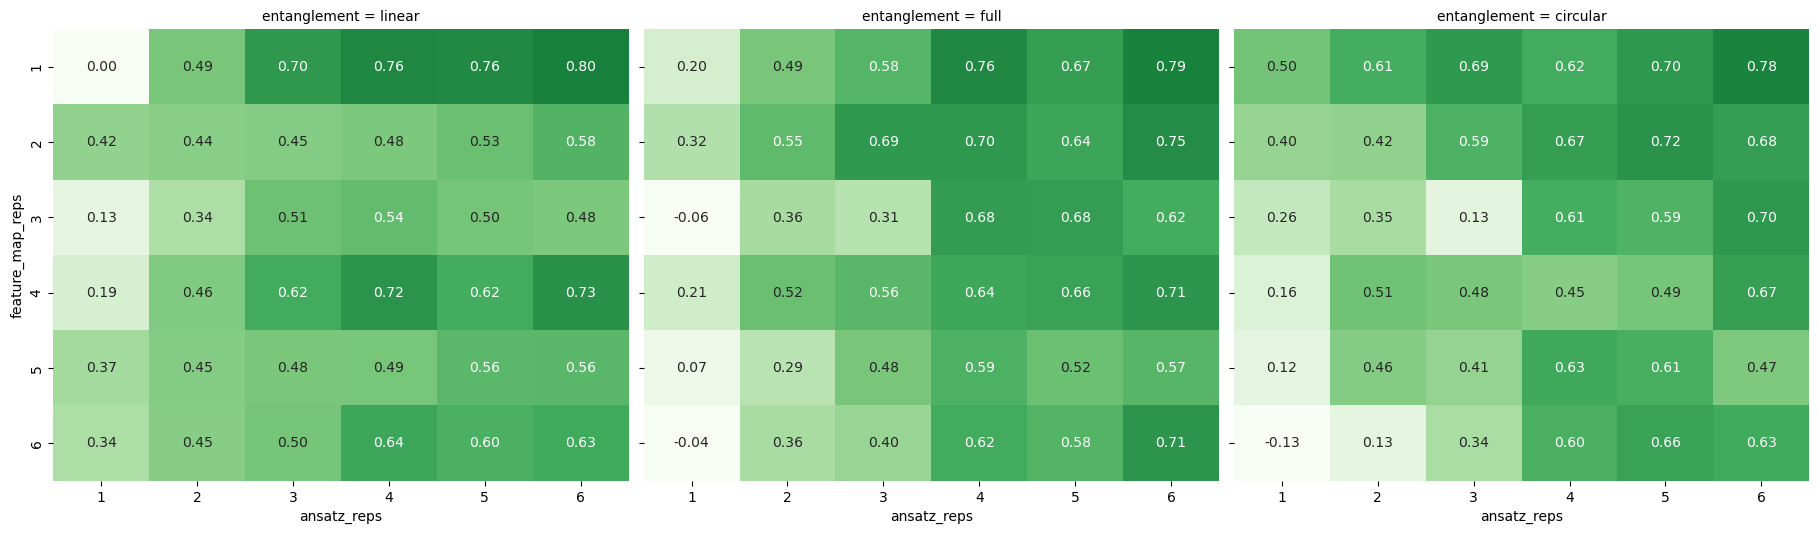

In [3]:
## Plot the data
df_output = pd.DataFrame(
 data=list(zip(output_entangle, output_feature_map_reps, output_ansatz_reps, output_r2, output_r2_all)),
 columns=["entanglement", "feature_map_reps", "ansatz_reps", "r2", "r2_all"]
)

# Pivot the data
pivot = df_output.pivot_table(
    index="feature_map_reps", columns="ansatz_reps", values="r2_all"
)

# Draw heatmap
g = sns.FacetGrid(
    df_output, col="entanglement",
    col_wrap=6, height=6, sharex=True, sharey=True
)
g.map_dataframe(
    lambda data, **kws: sns.heatmap(
        data.pivot_table(index="feature_map_reps", columns="ansatz_reps", values="r2_all"),
        vmin=0, vmax=1, annot=True, fmt=".2f", cbar=False, cmap="Greens"
    )
)
for ax in g.axes.flat:
    ax.set_xlabel("ansatz_reps"); ax.set_ylabel("feature_map_reps")
g.fig.subplots_adjust(top=0.85)
# g.fig.suptitle("Accuracy Heatmaps by Entanglement", fontsize=14)
# plt.savefig(f'QSVR/zz/figure/{date}.png')
plt.show()

# QSVR

In [4]:
if_del_outlier = False
# Read from all csv files
df_all = pd.DataFrame()
for filename in glob.glob("./QSVR/result/FMR*"):
    df_tmp = pd.read_csv(filename)
    df_all = pd.concat([df_all, df_tmp.drop(columns=['info'])], ignore_index=True)

# Get the unique list of all 
test_el_list = df_all['element test'].unique()
entangle_list = df_all['entanglement'].unique()
C_list = df_all['C'].unique()
C_list.sort()
reps_list = df_all['reps'].unique()
reps_list.sort()
epsilon_list = df_all['epsilon'].unique()
epsilon_list.sort()


output_entangle = []
output_C = []
output_reps = []
output_epsilon = []
output_r2 = []
output_r2_all = []

# Loop over testing parameters
for entangle in entangle_list:
    for C in C_list:
        for reps in reps_list:
            for epsilon in epsilon_list:
                # print(entangle, C, reps, epsilon)
                output_entangle.append(entangle)
                output_C.append(C)
                output_reps.append(reps)
                output_epsilon.append(epsilon)
                
                # get results for specified testing parameters
                df = df_all[(df_all['entanglement'] == entangle) 
                    & (df_all['C'] == C)
                    & (df_all['reps'] == reps)
                    & (df_all['epsilon'] == epsilon)]
    
                # One way to assess accuracy is to list all testing 
                # results (for different splits) and to take the R2 based on those.
                el_list = []
                predict_list = []
                actural_list = []
                for el in test_el_list:
                    # actual value
                    tmp2 = df[df['element test'] == el]['actual test']
                    actural_val = np.fromstring(tmp2.to_list()[0][1:-1], dtype=float, sep=" ")[0]
                
                    # predicted values
                    tmp = df[df['element test'] == el]['predicted test']
                    test_predict_list = []
                    for ii in tmp:
                        test_predict_list.append(np.fromstring(ii[1:-1], dtype=float, sep=" "))
                    test_predict_list = np.concatenate(test_predict_list)
                    test_predict_mean = test_predict_list.mean()
                
                    # find any outliers of predicted values
                    if if_del_outlier:
                        to_delete = []
                        for count, value in enumerate(test_predict_list):
                            if (value - test_predict_mean)/test_predict_mean > 0.01:
                                print('delete', entangle, feature_map_reps, ansatz_reps, el, value, test_predict_mean)
                                to_delete.append(count)
                        if len(to_delete) > 0:
                            test_predict_list = np.delete(test_predict_list, to_delete)
                            test_predict_mean = test_predict_list.mean()
                
                    #print(el, test_predict_list.std(), actural_val)
                    el_list.append(el[2:-2])
                    predict_list.append(test_predict_list.mean())
                    actural_list.append(actural_val)
                # print('R2', entangle, C, reps, epsilon, r2_score(actural_list, predict_list))
                output_r2.append(r2_score(actural_list, predict_list))
    
                # Another way to assess accuracy is to evaluate the R2 based on the dataset, 
                # including training and validation, and then take the average of those.
                el_list_2 = []
                r2_list = []
                for index, row in df.iterrows():
                    el_list_2.append(row['element test'][2:-2])
                    predicted = np.concatenate((np.fromstring(row['predicted train'][1:-1],dtype=float, sep=" "), np.fromstring(row['predicted test'][1:-1],dtype=float, sep=" ")))
                    actual = np.concatenate((np.fromstring(row['actual train'][1:-1],dtype=float, sep=" "), np.fromstring(row['actual test'][1:-1],dtype=float, sep=" ")))
                    r2_list.append(r2_score(actual, predicted))
                # print('R2_all', np.mean(r2_list), np.std(r2_list))
                output_r2_all.append(np.mean(r2_list))

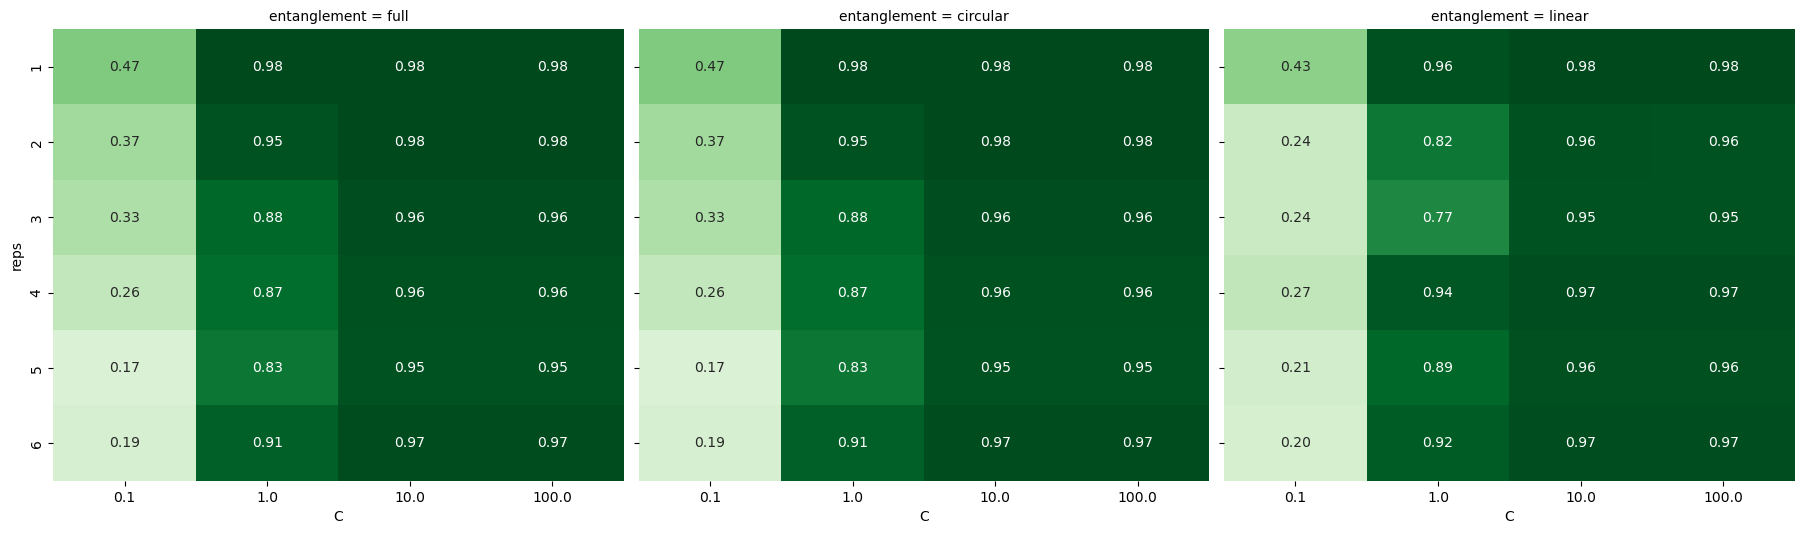

In [5]:
## Plot the data
df_output = pd.DataFrame(
 data=list(zip(output_entangle, output_C, output_reps, output_epsilon, output_r2, output_r2_all)),
 columns=["entanglement", "C", "reps", "epsilon", "r2", "r2_all"]
)

# Pivot the data
pivot = df_output.pivot_table(
    index="reps", columns="C", values="r2_all", 
)

# Draw heatmap
g = sns.FacetGrid(
    df_output, col="entanglement",
    col_wrap=4, height=6, sharex=True, sharey=True
)
g.map_dataframe(
    lambda data, **kws: sns.heatmap(
        data.pivot_table(index="reps", columns="C", values="r2_all", ),
        vmin=0, vmax=1, annot=True, fmt=".2f", cbar=False, cmap="Greens"
    )
)
for ax in g.axes.flat:
    ax.set_xlabel("C"); ax.set_ylabel("reps")
g.fig.subplots_adjust(top=0.85)
# g.fig.suptitle("Accuracy Heatmaps by Entanglement", fontsize=14)
# plt.savefig(f'QSVR/zz/figure/{date}.png')
plt.show()

# VQR

In [2]:
if_del_outlier = False
# Read from all csv files
df_all = pd.DataFrame()
for filename in glob.glob("./VQR/result/FMR*"):
    df_tmp = pd.read_csv(filename)
    df_all = pd.concat([df_all, df_tmp.drop(columns=['info'])], ignore_index=True)

# Get the unique list of all 
entangle_list = df_all['entanglement'].unique()
feature_map_reps_list = df_all['feature_map_reps'].unique()
feature_map_reps_list.sort()
ansatz_reps_list = df_all['ansatz_reps'].unique()
ansatz_reps_list.sort()

output_feature_map_name = []
output_entangle = []
output_feature_map_reps = []
output_ansatz_reps = []
output_r2 = []
output_r2_all = []

# Loop over testing parameters
for feature_map_name in ['Pauli', 'ZZ']:
    for entangle in entangle_list:
        for feature_map_reps in feature_map_reps_list:
            for ansatz_reps in ansatz_reps_list:
                # print(entangle, feature_map_reps, ansatz_reps)
                output_feature_map_name.append(feature_map_name)
                output_entangle.append(entangle)
                output_feature_map_reps.append(feature_map_reps)
                output_ansatz_reps.append(ansatz_reps)
                
                # get results for specified testing parameters
                df = df_all[(df_all['feature_map_name'] == feature_map_name)
                    & (df_all['entanglement'] == entangle) 
                    & (df_all['feature_map_reps'] == feature_map_reps)
                    & (df_all['ansatz_reps'] == ansatz_reps)]
                if df.empty:
                    continue
                test_el_list = df['element test'].unique()
    
                # One way to assess accuracy is to list all testing 
                # results (for different splits) and to take the R2 based on those.
                el_list = []
                predict_list = []
                actural_list = []
                for el in test_el_list:
                    # actual value
                    tmp2 = df[df['element test'] == el]['actual test']
                    actural_val = np.fromstring(tmp2.to_list()[0][1:-1], dtype=float, sep=" ")[0]
                
                    # predicted values
                    tmp = df[df['element test'] == el]['predicted test']
                    test_predict_list = []
                    for ii in tmp:
                        test_predict_list.append(np.fromstring(ii[1:-1], dtype=float, sep=" "))
                    test_predict_list = np.concatenate(test_predict_list)
                    test_predict_mean = test_predict_list.mean()
                
                    # find any outliers of predicted values
                    if if_del_outlier:
                        to_delete = []
                        for count, value in enumerate(test_predict_list):
                            if (value - test_predict_mean)/test_predict_mean > 0.01:
                                print('delete', entangle, feature_map_reps, ansatz_reps, el, value, test_predict_mean)
                                to_delete.append(count)
                        if len(to_delete) > 0:
                            test_predict_list = np.delete(test_predict_list, to_delete)
                            test_predict_mean = test_predict_list.mean()
                
                    # print(el, test_predict_list.std(), actural_val)
                    el_list.append(el[2:-2])
                    predict_list.append(test_predict_list.mean())
                    actural_list.append(actural_val)
                # print('R2', entangle, feature_map_reps, ansatz_reps, r2_score(actural_list, predict_list))
                output_r2.append(r2_score(actural_list, predict_list))
    
                # Another way to assess accuracy is to evaluate the R2 based on the dataset, 
                # including training and validation, and then take the average of those.
                el_list_2 = []
                r2_list = []
                for index, row in df.iterrows():
                    el_list_2.append(row['element test'][2:-2])
                    predicted = np.concatenate((np.fromstring(row['predicted train'][1:-1],dtype=float, sep=" "), np.fromstring(row['predicted test'][1:-1],dtype=float, sep=" ")))
                    actual = np.concatenate((np.fromstring(row['actual train'][1:-1],dtype=float, sep=" "), np.fromstring(row['actual test'][1:-1],dtype=float, sep=" ")))
                    r2_list.append(r2_score(actual, predicted))
                # print('R2_all', np.mean(r2_list), np.std(r2_list))
                output_r2_all.append(np.mean(r2_list))

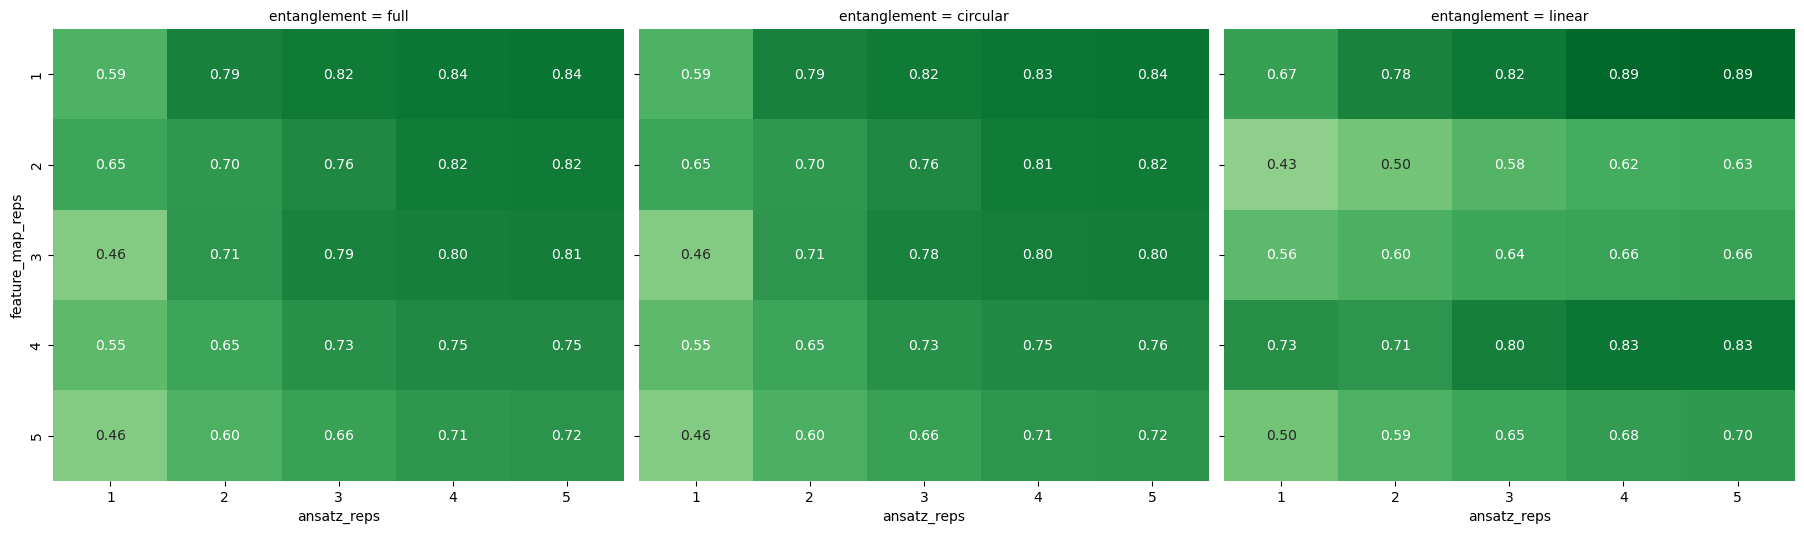

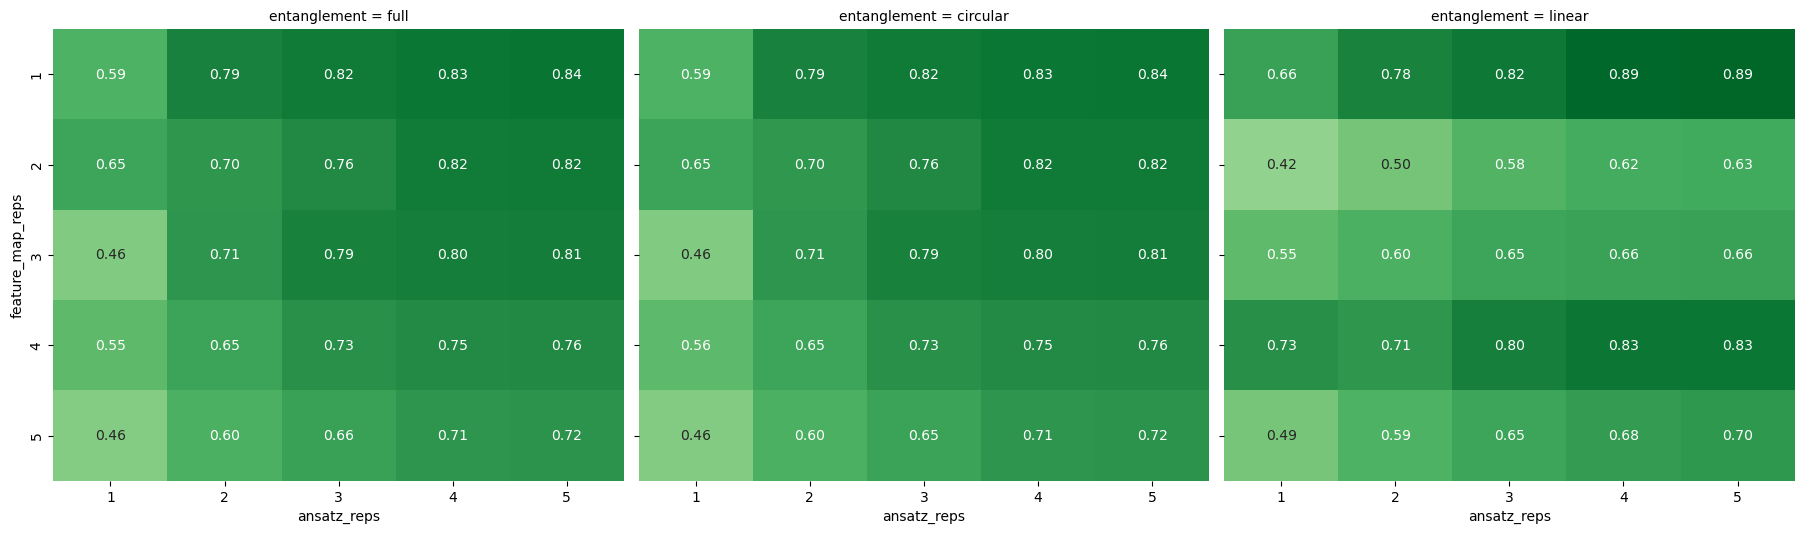

In [3]:
## Plot the data
df_output_all = pd.DataFrame(
 data=list(zip(output_entangle, output_feature_map_name, output_feature_map_reps, output_ansatz_reps, output_r2, output_r2_all)),
 columns=["entanglement", "feature_map_name", "feature_map_reps", "ansatz_reps", "r2", "r2_all"]
)

for feature_map_name in ['Pauli', 'ZZ']:
    df_output = df_output_all[df_output_all['feature_map_name'] == feature_map_name]
    
    # Pivot the data
    pivot = df_output.pivot_table(
        index="feature_map_reps", columns="ansatz_reps", values="r2_all", 
    )
    
    # Draw heatmap
    g = sns.FacetGrid(
        df_output, col="entanglement",
        col_wrap=4, height=6, sharex=True, sharey=True
    )
    g.map_dataframe(
        lambda data, **kws: sns.heatmap(
            data.pivot_table(index="feature_map_reps", columns="ansatz_reps", values="r2_all", ),
            vmin=0, vmax=1, annot=True, fmt=".2f", cbar=False, cmap="Greens"
        )
    )
    for ax in g.axes.flat:
        ax.set_xlabel("ansatz_reps"); ax.set_ylabel("feature_map_reps")
    g.fig.subplots_adjust(top=0.85)
    # g.fig.suptitle("Accuracy Heatmaps by Entanglement", fontsize=14)
    # plt.savefig(f'QSVR/zz/figure/{date}.png')
    plt.show()

# QNNC

In [6]:
# Read from all csv files
df_all = pd.DataFrame()
for filename in glob.glob("./QNNC_hybrid/result/FMR*28_19_25_1.csv"):
    df_tmp = pd.read_csv(filename)
    df_all = pd.concat([df_all, df_tmp.drop(columns=['info'])], ignore_index=True)

# Get the unique list of all 
test_el_list = df_all['element test'].unique()
entangle_list = df_all['entanglement'].unique()
feature_map_reps_list = df_all['feature_map_reps'].unique()
feature_map_reps_list.sort()
ansatz_reps_list = df_all['ansatz_reps'].unique()
ansatz_reps_list.sort()

output_entangle = []
output_feature_map_reps = []
output_ansatz_reps = []
output_r2 = []
output_r2_all = []

# Loop over testing parameters
for entangle in entangle_list:
    for feature_map_reps in feature_map_reps_list:
        for ansatz_reps in ansatz_reps_list:
            # print(entangle, feature_map_reps, ansatz_reps)
            output_entangle.append(entangle)
            output_feature_map_reps.append(feature_map_reps)
            output_ansatz_reps.append(ansatz_reps)
            
            # get results for specified testing parameters
            df = df_all[(df_all['entanglement'] == entangle) 
                & (df_all['feature_map_reps'] == feature_map_reps)
                & (df_all['ansatz_reps'] == ansatz_reps)]

            # One way to assess accuracy is to list all testing 
            # results (for different splits) and to take the R2 based on those.
            el_list = []
            predict_list = []
            actural_list = []
            for el in test_el_list:
                # actual value
                tmp2 = df[df['element test'] == el]['actual test']
                actural_val = np.fromstring(tmp2.to_list()[0][1:-1], dtype=np.long, sep=" ")[0]
            
                # predicted values
                tmp = df[df['element test'] == el]['predicted test']
                test_predict_list = []
                for ii in tmp:
                    test_predict_list.append(np.fromstring(ii[1:-1], dtype=np.long, sep=" "))
                test_predict_list = np.concatenate(test_predict_list)
                test_predict_mean = test_predict_list.mean()
            
                #print(el, test_predict_list.std(), actural_val)
                el_list.append(el[2:-2])
                predict_list.append(test_predict_list.mean())
                actural_list.append(actural_val)
            # print('R2', entangle, feature_map_reps, ansatz_reps, r2_score(actural_list, predict_list))
            output_r2.append(r2_score(actural_list, predict_list))

            # Another way to assess accuracy is to evaluate the R2 based on the dataset, 
            # including training and validation, and then take the average of those.
            el_list_2 = []
            r2_list = []
            for index, row in df.iterrows():
                el_list_2.append(row['element test'][2:-2])
                predicted = np.concatenate((np.fromstring(row['predicted train'][1:-1],dtype=np.long, sep=" "), np.fromstring(row['predicted test'][1:-1],dtype=np.long, sep=" ")))
                actual = np.concatenate((np.fromstring(row['actual train'][1:-1],dtype=np.long, sep=" "), np.fromstring(row['actual test'][1:-1],dtype=np.long, sep=" ")))
                r2_list.append(r2_score(actual, predicted))
            # print('R2_all', np.mean(r2_list), np.std(r2_list))
            output_r2_all.append(np.mean(r2_list))

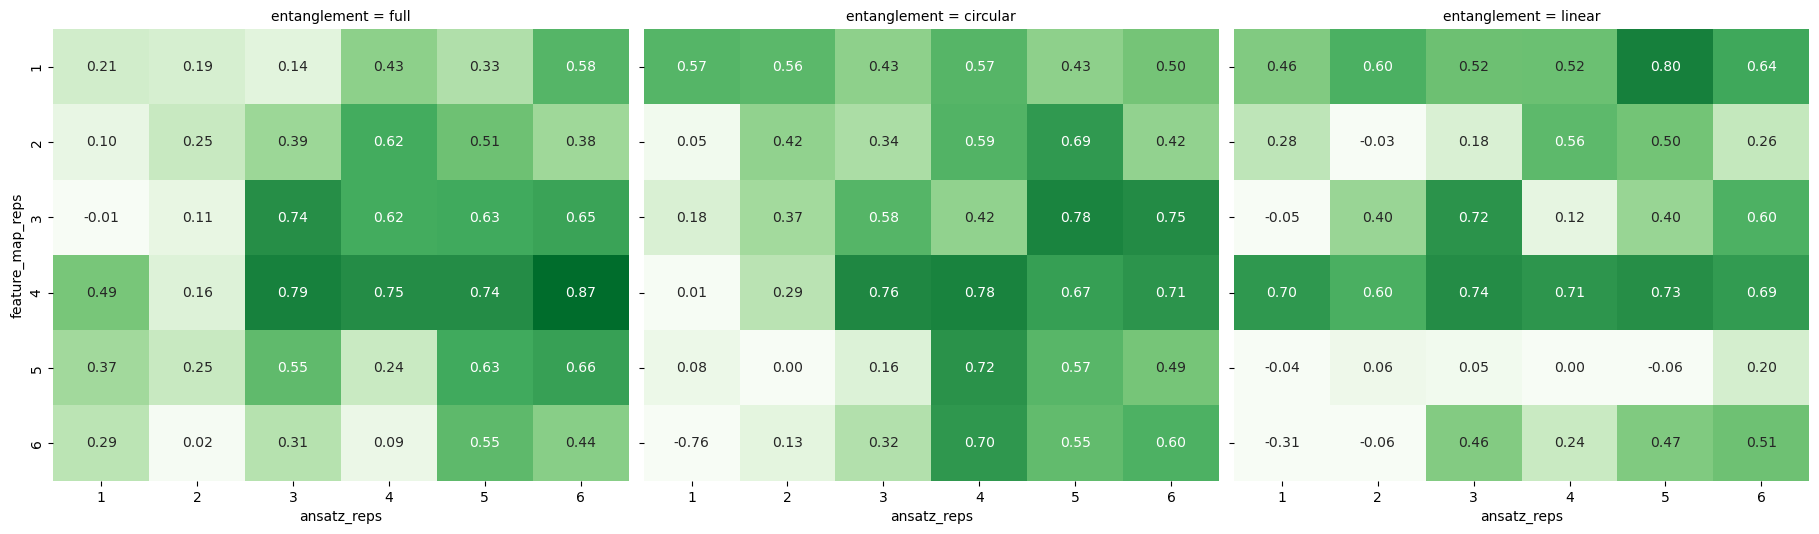

In [7]:
## Plot the data
df_output = pd.DataFrame(
 data=list(zip(output_entangle, output_feature_map_reps, output_ansatz_reps, output_r2, output_r2_all)),
 columns=["entanglement", "feature_map_reps", "ansatz_reps", "r2", "r2_all"]
)

# Pivot the data
pivot = df_output.pivot_table(
    index="feature_map_reps", columns="ansatz_reps", values="r2_all"
)

# Draw heatmap
g = sns.FacetGrid(
    df_output, col="entanglement",
    col_wrap=6, height=6, sharex=True, sharey=True
)
g.map_dataframe(
    lambda data, **kws: sns.heatmap(
        data.pivot_table(index="feature_map_reps", columns="ansatz_reps", values="r2_all"),
        vmin=0, vmax=1, annot=True, fmt=".2f", cbar=False, cmap="Greens"
    )
)
for ax in g.axes.flat:
    ax.set_xlabel("ansatz_reps"); ax.set_ylabel("feature_map_reps")
g.fig.subplots_adjust(top=0.85)
# g.fig.suptitle("Accuracy Heatmaps by Entanglement", fontsize=14)
# plt.savefig(f'QSVR/zz/figure/{date}.png')
plt.show()

# QSVC

In [8]:
# Read from all csv files
df_all = pd.DataFrame()
for filename in glob.glob("./QSVC/result/FMR*28_19_25_1.csv"):
    df_tmp = pd.read_csv(filename)
    df_all = pd.concat([df_all, df_tmp.drop(columns=['info'])], ignore_index=True)

# Get the unique list of all 
test_el_list = df_all['element test'].unique()
entangle_list = df_all['entanglement'].unique()
C_list = df_all['C'].unique()
C_list.sort()
reps_list = df_all['reps'].unique()
reps_list.sort()

output_entangle = []
output_C = []
output_reps = []
output_r2 = []
output_r2_all = []

# Loop over testing parameters
for entangle in entangle_list:
    for C in C_list:
        for reps in reps_list:
            # print(entangle, C, reps)
            output_entangle.append(entangle)
            output_C.append(C)
            output_reps.append(reps)
            
            # get results for specified testing parameters
            df = df_all[(df_all['entanglement'] == entangle) 
                & (df_all['C'] == C)
                & (df_all['reps'] == reps)]

            # One way to assess accuracy is to list all testing 
            # results (for different splits) and to take the R2 based on those.
            el_list = []
            predict_list = []
            actural_list = []
            for el in test_el_list:
                # actual value
                tmp2 = df[df['element test'] == el]['actual test']
                tmp_str = tmp2.to_list()[0][1:-1].replace("1.", "1").replace("0.", "0")
                actural_val = np.fromstring(tmp_str, dtype=np.long, sep=" ")[0]
            
                # predicted values
                tmp = df[df['element test'] == el]['predicted test']
                test_predict_list = []
                for ii in tmp:
                    tmp_str = ii[1:-1].replace("1.", "1").replace("0.", "0")
                    test_predict_list.append(np.fromstring(tmp_str, dtype=np.long, sep=" "))
                test_predict_list = np.concatenate(test_predict_list)
                test_predict_mean = test_predict_list.mean()
            
                #print(el, test_predict_list.std(), actural_val)
                el_list.append(el[2:-2])
                predict_list.append(test_predict_list.mean())
                actural_list.append(actural_val)
            # print('R2', entangle, C, reps, r2_score(actural_list, predict_list))
            output_r2.append(r2_score(actural_list, predict_list))

            # Another way to assess accuracy is to evaluate the R2 based on the dataset, 
            # including training and validation, and then take the average of those.
            el_list_2 = []
            r2_list = []
            for index, row in df.iterrows():
                el_list_2.append(row['element test'][2:-2])
                tmp_str_1 = row['predicted train'][1:-1].replace("1.", "1").replace("0.", "0")
                tmp_str_2 = row['predicted test'][1:-1].replace("1.", "1").replace("0.", "0")
                tmp_str_3 = row['actual train'][1:-1].replace("1.", "1").replace("0.", "0")
                tmp_str_4 = row['actual test'][1:-1].replace("1.", "1").replace("0.", "0")
                predicted = np.concatenate((np.fromstring(tmp_str_1, dtype=np.long, sep=" "), np.fromstring(tmp_str_2, dtype=np.long, sep=" ")))
                actual = np.concatenate((np.fromstring(tmp_str_3, dtype=np.long, sep=" "), np.fromstring(tmp_str_4, dtype=np.long, sep=" ")))
                r2_list.append(r2_score(actual, predicted))
            # print('R2_all', np.mean(r2_list), np.std(r2_list))
            output_r2_all.append(np.mean(r2_list))

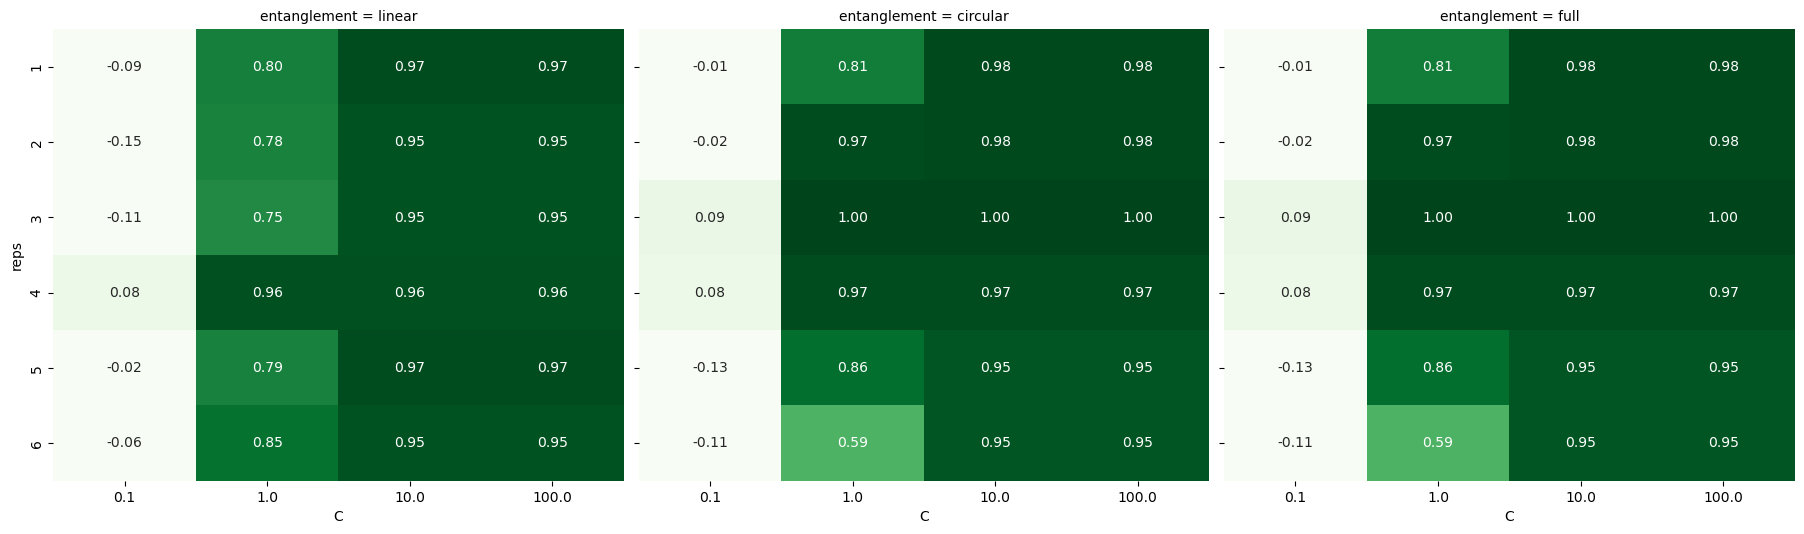

In [9]:
## Plot the data
df_output = pd.DataFrame(
 data=list(zip(output_entangle, output_C, output_reps, output_r2, output_r2_all)),
 columns=["entanglement", "C", "reps", "r2", "r2_all"]
)

# Pivot the data
pivot = df_output.pivot_table(
    index="reps", columns="C", values="r2_all", 
)

# Draw heatmap
g = sns.FacetGrid(
    df_output, col="entanglement",
    col_wrap=4, height=6, sharex=True, sharey=True
)
g.map_dataframe(
    lambda data, **kws: sns.heatmap(
        data.pivot_table(index="reps", columns="C", values="r2_all", ),
        vmin=0, vmax=1, annot=True, fmt=".2f", cbar=False, cmap="Greens"
    )
)
for ax in g.axes.flat:
    ax.set_xlabel("C"); ax.set_ylabel("reps")
g.fig.subplots_adjust(top=0.85)
# g.fig.suptitle("Accuracy Heatmaps by Entanglement", fontsize=14)
# plt.savefig(f'QSVR/zz/figure/{date}.png')
plt.show()

# VQC

In [4]:
if_del_outlier = False
# Read from all csv files
df_all = pd.DataFrame()
for filename in glob.glob("./VQC/result/FMR*"):
    df_tmp = pd.read_csv(filename)
    df_all = pd.concat([df_all, df_tmp.drop(columns=['info'])], ignore_index=True)

# Get the unique list of all 
entangle_list = df_all['entanglement'].unique()
feature_map_reps_list = df_all['feature_map_reps'].unique()
feature_map_reps_list.sort()
ansatz_reps_list = df_all['ansatz_reps'].unique()
ansatz_reps_list.sort()

output_feature_map_name = []
output_entangle = []
output_feature_map_reps = []
output_ansatz_reps = []
output_r2 = []
output_r2_all = []

# Loop over testing parameters
for feature_map_name in ['Pauli', 'ZZ']:
    for entangle in entangle_list:
        for feature_map_reps in feature_map_reps_list:
            for ansatz_reps in ansatz_reps_list:
                # print(entangle, feature_map_reps, ansatz_reps)
                output_feature_map_name.append(feature_map_name)
                output_entangle.append(entangle)
                output_feature_map_reps.append(feature_map_reps)
                output_ansatz_reps.append(ansatz_reps)
                
                # get results for specified testing parameters
                df = df_all[(df_all['feature_map_name'] == feature_map_name)
                    & (df_all['entanglement'] == entangle) 
                    & (df_all['feature_map_reps'] == feature_map_reps)
                    & (df_all['ansatz_reps'] == ansatz_reps)]
                if df.empty:
                    continue
                test_el_list = df['element test'].unique()
    
                # One way to assess accuracy is to list all testing 
                # results (for different splits) and to take the R2 based on those.
                el_list = []
                predict_list = []
                actural_list = []
                for el in test_el_list:
                    # actual value
                    tmp2 = df[df['element test'] == el]['actual test']
                    actural_val = np.fromstring(tmp2.to_list()[0][1:-1], dtype=float, sep=" ")[0]
                
                    # predicted values
                    tmp = df[df['element test'] == el]['predicted test']
                    test_predict_list = []
                    for ii in tmp:
                        test_predict_list.append(np.fromstring(ii[1:-1], dtype=float, sep=" "))
                    test_predict_list = np.concatenate(test_predict_list)
                    test_predict_mean = test_predict_list.mean()
                
                    # find any outliers of predicted values
                    if if_del_outlier:
                        to_delete = []
                        for count, value in enumerate(test_predict_list):
                            if (value - test_predict_mean)/test_predict_mean > 0.01:
                                print('delete', entangle, feature_map_reps, ansatz_reps, el, value, test_predict_mean)
                                to_delete.append(count)
                        if len(to_delete) > 0:
                            test_predict_list = np.delete(test_predict_list, to_delete)
                            test_predict_mean = test_predict_list.mean()
                
                    # print(el, test_predict_list.std(), actural_val)
                    el_list.append(el[2:-2])
                    predict_list.append(test_predict_list.mean())
                    actural_list.append(actural_val)
                # print('R2', entangle, feature_map_reps, ansatz_reps, r2_score(actural_list, predict_list))
                output_r2.append(r2_score(actural_list, predict_list))
    
                # Another way to assess accuracy is to evaluate the R2 based on the dataset, 
                # including training and validation, and then take the average of those.
                el_list_2 = []
                r2_list = []
                for index, row in df.iterrows():
                    el_list_2.append(row['element test'][2:-2])
                    predicted = np.concatenate((np.fromstring(row['predicted train'][1:-1],dtype=float, sep=" "), np.fromstring(row['predicted test'][1:-1],dtype=float, sep=" ")))
                    actual = np.concatenate((np.fromstring(row['actual train'][1:-1],dtype=float, sep=" "), np.fromstring(row['actual test'][1:-1],dtype=float, sep=" ")))
                    r2_list.append(r2_score(actual, predicted))
                # print('R2_all', np.mean(r2_list), np.std(r2_list))
                output_r2_all.append(np.mean(r2_list))

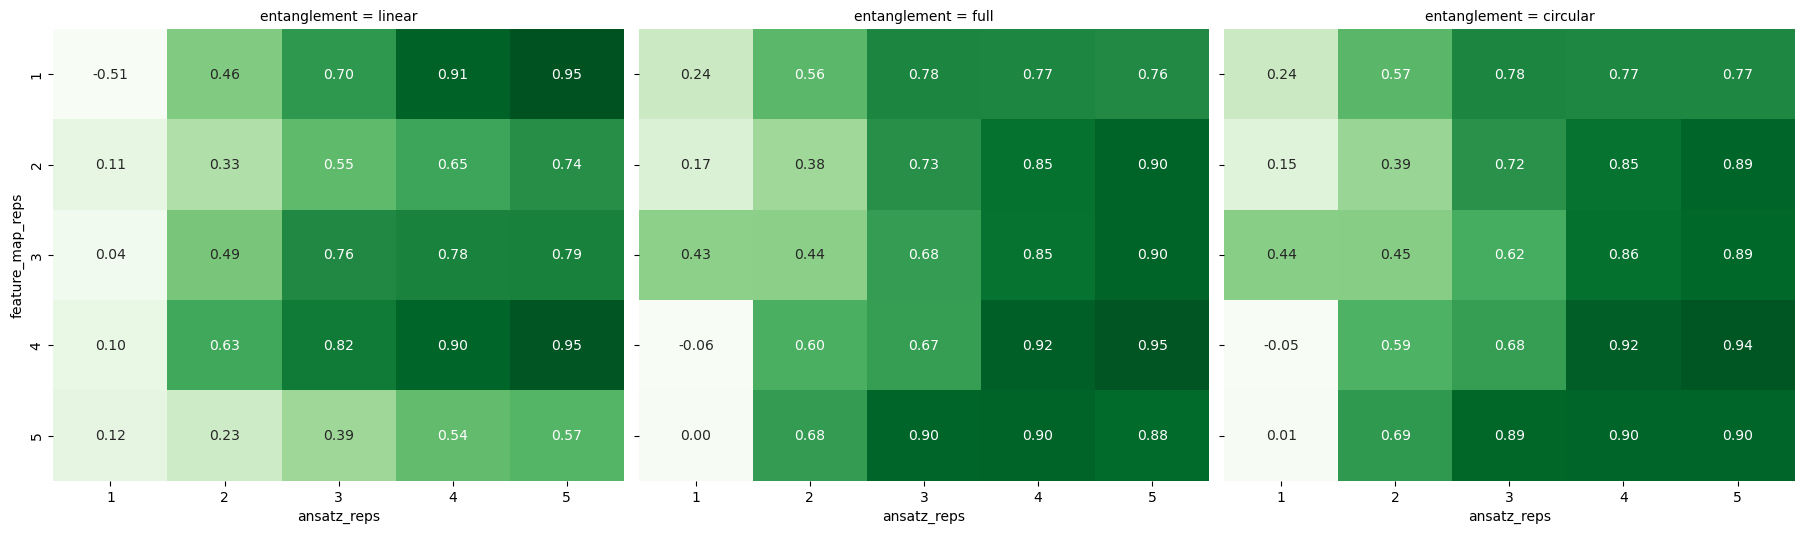

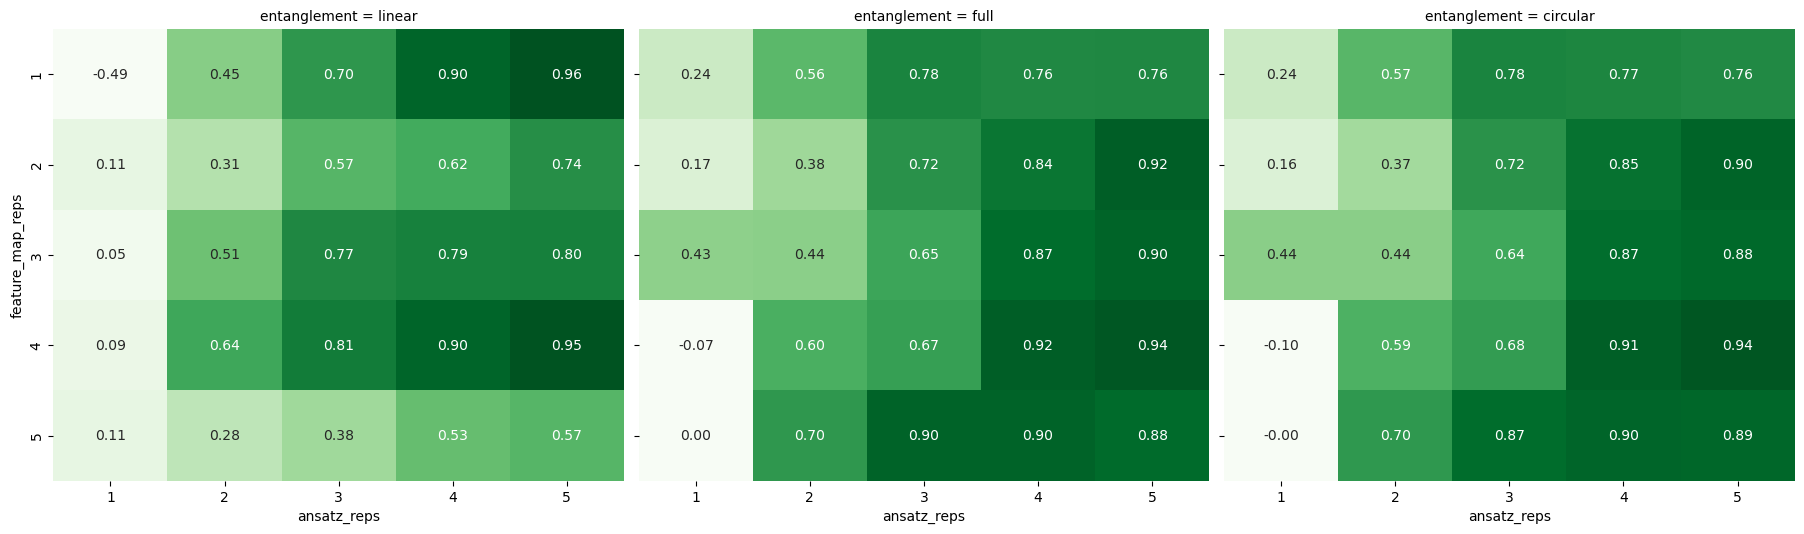

In [5]:
## Plot the data
df_output_all = pd.DataFrame(
 data=list(zip(output_entangle, output_feature_map_name, output_feature_map_reps, output_ansatz_reps, output_r2, output_r2_all)),
 columns=["entanglement", "feature_map_name", "feature_map_reps", "ansatz_reps", "r2", "r2_all"]
)

for feature_map_name in ['Pauli', 'ZZ']:
    df_output = df_output_all[df_output_all['feature_map_name'] == feature_map_name]
    
    # Pivot the data
    pivot = df_output.pivot_table(
        index="feature_map_reps", columns="ansatz_reps", values="r2_all", 
    )
    
    # Draw heatmap
    g = sns.FacetGrid(
        df_output, col="entanglement",
        col_wrap=4, height=6, sharex=True, sharey=True
    )
    g.map_dataframe(
        lambda data, **kws: sns.heatmap(
            data.pivot_table(index="feature_map_reps", columns="ansatz_reps", values="r2_all", ),
            vmin=0, vmax=1, annot=True, fmt=".2f", cbar=False, cmap="Greens"
        )
    )
    for ax in g.axes.flat:
        ax.set_xlabel("ansatz_reps"); ax.set_ylabel("feature_map_reps")
    g.fig.subplots_adjust(top=0.85)
    # g.fig.suptitle("Accuracy Heatmaps by Entanglement", fontsize=14)
    # plt.savefig(f'QSVR/zz/figure/{date}.png')
    plt.show()